In [12]:
'''
Author: Naiyuan liu
Github: https://github.com/NNNNAI
Date: 2021-11-23 17:03:58
LastEditors: Naiyuan liu
LastEditTime: 2021-11-24 19:00:38
Description: 
'''

import cv2
import torch
import fractions
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from models.models import create_model
from options.test_options import TestOptions
from insightface_func.face_detect_crop_single import Face_detect_crop
from util.videoswap import video_swap
import os

def lcm(a, b): return abs(a * b) / fractions.gcd(a, b) if a and b else 0

transformer = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transformer_Arcface = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# detransformer = transforms.Compose([
#         transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
#         transforms.Normalize([-0.485, -0.456, -0.406], [1, 1, 1])
#     ])


os.chdir('/mp/nas2/ruihan/computer_vision/SimSwap')
def simswap_ruihan(pic_a_path,video_path,output_path):
    opt = TestOptions()
    opt.initialize()
    opt.parser.add_argument('-f') ## dummy arg to avoid bug
    opt = opt.parse()
    
    opt.pic_a_path = pic_a_path 
    opt.video_path = video_path 
    opt.output_path = output_path 
    opt.temp_path = './tmp'
    opt.Arc_path = './arcface_model/arcface_checkpoint.tar'
    opt.isTrain = False
    opt.use_mask = True  ## new feature up-to-date
    opt.crop_size = 512
    opt.name = '512'
    opt.which_epoch = 550000

    start_epoch, epoch_iter = 1, 0
    crop_size = opt.crop_size

    torch.nn.Module.dump_patches = True
    if crop_size == 512:
        opt.which_epoch = 550000
        opt.name = '512'
        mode = 'ffhq'
    else:
        mode = 'None'
    model = create_model(opt)
    model.eval()


    app = Face_detect_crop(name='antelope', root='./insightface_func/models')
    app.prepare(ctx_id= 0, det_thresh=0.3, det_size=(640,640),mode=mode)
    with torch.no_grad():
        pic_a = opt.pic_a_path
        # img_a = Image.open(pic_a).convert('RGB')
        img_a_whole = cv2.imread(pic_a)
        plt.imshow(img_a_whole)
        img_a_align_crop, _ = app.get(img_a_whole,crop_size)
        img_a_align_crop_pil = Image.fromarray(cv2.cvtColor(img_a_align_crop[0],cv2.COLOR_BGR2RGB)) 
        img_a = transformer_Arcface(img_a_align_crop_pil)
        img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])

        # pic_b = opt.pic_b_path
        # img_b_whole = cv2.imread(pic_b)
        # img_b_align_crop, b_mat = app.get(img_b_whole,crop_size)
        # img_b_align_crop_pil = Image.fromarray(cv2.cvtColor(img_b_align_crop,cv2.COLOR_BGR2RGB)) 
        # img_b = transformer(img_b_align_crop_pil)
        # img_att = img_b.view(-1, img_b.shape[0], img_b.shape[1], img_b.shape[2])

        # convert numpy to tensor
        img_id = img_id.cuda()
        # img_att = img_att.cuda()

        #create latent id
        img_id_downsample = F.interpolate(img_id, size=(112,112))
        latend_id = model.netArc(img_id_downsample)
        latend_id = F.normalize(latend_id, p=2, dim=1)

        video_swap(opt.video_path, latend_id, model, app, opt.output_path,temp_results_dir=opt.temp_path,\
            no_simswaplogo=True,use_mask=opt.use_mask,crop_size=crop_size)

------------ Options -------------
Arc_path: models/BEST_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
crop_size: 224
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
f: /home/ruihan/.local/share/jupyter/runtime/kernel-9aa71e1f-c09b-4fad-b18a-d0a589e0bbf7.json
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesyncbatch3x3
nte

 97%|█████████▋| 253/260 [09:12<00:15,  2.18s/it]


Moviepy - Building video /mp/nas2/ruihan/computer_vision/Face/output/shangdi_simswap_512_from_0.mp4.
MoviePy - Writing audio in shangdi_simswap_512_from_0TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /mp/nas2/ruihan/computer_vision/Face/output/shangdi_simswap_512_from_0.mp4



Moviepy - Done !
Moviepy - video ready /mp/nas2/ruihan/computer_vision/Face/output/shangdi_simswap_512_from_0.mp4


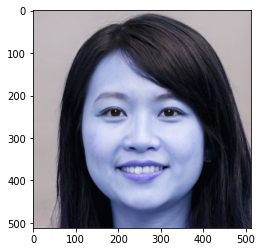

In [14]:
for i in range(1):
    # pic_a_path = '/mp/nas2/ruihan/computer_vision/Face/recommended4_qing/{}.jpg'.format(i)
    # video_path = '/mp/nas2/ruihan/computer_vision/Face/qing/qing.mp4'
    # output_path = '/mp/nas2/ruihan/computer_vision/Face/output/qing_simswap_512_from_{}.mp4'.format(i)
    # simswap_ruihan(pic_a_path,video_path,output_path)

    # pic_a_path = '/mp/nas2/ruihan/computer_vision/Face/recommended4_xirui/{}.jpg'.format(i)
    # video_path = '/mp/nas2/ruihan/computer_vision/Face/xirui/xirui.mp4'
    # output_path = '/mp/nas2/ruihan/computer_vision/Face/output/xirui_simswap_512_from_{}.mp4'.format(i)
    # simswap_ruihan(pic_a_path,video_path,output_path)

    pic_a_path = '/mp/nas2/ruihan/computer_vision/Face/recommended4_shangdi/{}.jpg'.format(i)
    video_path = '/mp/nas2/ruihan/computer_vision/Face/shangdi/shangdi.mp4'
    output_path = '/mp/nas2/ruihan/computer_vision/Face/output/shangdi_simswap_512_from_{}.mp4'.format(i)
    simswap_ruihan(pic_a_path,video_path,output_path)

    # pic_a_path = '/mp/nas2/ruihan/computer_vision/Face/recommended4_mengke/{}.jpg'.format(i)
    # video_path = '/mp/nas2/ruihan/computer_vision/Face/mengke/mengke.mp4'
    # output_path = '/mp/nas2/ruihan/computer_vision/Face/output/mengke_simswap_512_from_{}.mp4'.format(i)
    # simswap_ruihan(pic_a_path,video_path,output_path)
    
    # pic_a_path = '/mp/nas2/ruihan/computer_vision/Face/recommended4_qing/1.jpg'#.format(i)
    # video_path = '/mp/nas2/ruihan/computer_vision/Face/shangdi/shangdi.mp4'
    # output_path = '/mp/nas2/ruihan/computer_vision/Face/output/shangdi_simswap_512_from_qing_1.mp4'#.format(i)
    # simswap_ruihan(pic_a_path,video_path,output_path)

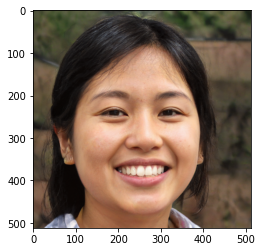

In [5]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(pic_a_path))
img_a = Image.open(pic_a_path).convert('RGB')